In [ ]:
!pip install SHAP
!pip install category_encoders
!pip install scikit-uplift

In [ ]:
import pandas as pd
import numpy as np
import category_encoders as ce
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from sklift.datasets import fetch_hillstrom
from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

import os
import shap
import numpy as np
import pandas as pd
from matplotlib import pyplot
import io
from google.colab import drive

In [ ]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
path_events = "/drive/My Drive/Master/JunctionX/events_junction.csv"
path_rewards = "/drive/My Drive/Master/JunctionX/rewards_junction.csv"
path_activities = "/drive/My Drive/Master/JunctionX/activities_junction.csv"

In [ ]:
data_events = pd.read_csv(path_events, nrows=1100000)
data_rewards = pd.read_csv(path_rewards)
data_activities = pd.read_csv(path_activities)

Columns (4,18,19) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
data_events_df = data_events
data_rewards_df = data_rewards
data_activities_df = data_activities

In [ ]:
data_events.shape

(1100000, 60)

In [ ]:
data_events_df.head()

,_id,timestamp,unix_timestamp,date,customer,action,points,properties.transaction_id,properties.total,properties.points_burned,...,properties.marketing_optin,properties.occupation,properties.website,properties.has_kid,properties.purchase_count,properties.on_sale,properties.special_price,properties.magento_website_id,properties.giftcard_expires_at,properties.product_id
0,5eddd4b0bc4bfd67cf8b58b9,2020-06-08T06:03:28.502Z,1591596208,2020-06-08T00:00:00.000Z,3104,checkout,358,LBSG002949868,357.94,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5eddd4c6bf4bfdbecc8b5a60,2020-06-08T06:03:50.604Z,1591596230,2020-06-08T00:00:00.000Z,70175,checkout,40,LBSG002949862,39.90,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5eddd4f2bf4bfdbecc8b5b47,2020-06-08T06:04:34.945Z,1591596274,2020-06-08T00:00:00.000Z,65947,checkout,111,LBSG002949871,110.24,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5eddd4fbbf4bfdbecc8b5b7a,2020-06-08T06:04:43.360Z,1591596283,2020-06-08T00:00:00.000Z,304754,checkout,47,LBSG002949874,46.90,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5eddd50ebc4bfd97cf8b5c99,2020-06-08T06:05:02.712Z,1591596302,2020-06-08T00:00:00.000Z,1878,checkout,148,LBSG002949877,147.40,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_rewards_df.head()

,_id,order,created_at,updated_at,type,name,description,redeem_instructions.en,category,button_label,...,cf_auto_claim,transferable,transfer_limit,transfer_points,coupon_expiration_time,coupon_notifications.NONE,coupon_notifications.SGD,cost,transfer_coupon_expiration,transfer_coupon_expires_in
0,5dc276fe2cf1904e6d8b4656,0,2019-11-06T07:32:14.706Z,2019-11-06T07:32:14.706Z,bidding,Demo reward name #1,Demo reward description #1,NaN,NaN,[ ],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5dc4124c2cf19092608b456d,1,2019-11-07T12:47:08.922Z,2019-11-07T14:00:35.319Z,download,Demo reward name #2,Demo reward description #2,You can find your coupon in your mailbox.,5dc40afa2cf190d0608b456b,[ ],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5dc41ebb2cf190c7608b4571,3,NaN,2019-11-07T13:40:11.066Z,download,Demo reward name #3,Demo reward description #3,You can find your coupon in your mailbox.,5dc40afa2cf190d0608b456b,[ ],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5dc41f302cf190a4608b4596,2,2019-11-07T13:42:08.487Z,2019-11-07T14:07:52.549Z,coupon,Demo reward name #4,Demo reward description #4,You can find your coupon in your mailbox.,5dc40afa2cf190d0608b456b,[ ],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5e40cfcb2cf190de628b4939,0,2020-02-10T03:36:43.622Z,2020-02-10T03:39:11.880Z,virtual,Demo reward name #5,Demo reward description #5,Not sure how to redeem tho,5e40d0142cf190eb628b4790,[ ],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_activities_df.head()

,_id,created_at,created_by,updated_at,updated_by,activated_at,name.en,description.en,phrase_feed.en,url,...,webhook_data,hide_restricted,restricted_message,status,display_coming_soon,segment.0,hidden,resetable,starts_at,ends_at


In [ ]:
def drop_useless_columns(df):
  useless_columns = list()
  for col in df:
    unique_values = df[col].unique()
    if len(unique_values) < 2:
      useless_columns.append(col)
  
  df = df.drop(useless_columns, axis=1)
  return df

def get_columns_worth_keeping(number, df):
  cols = list()
  for col in df: 
    unique_values = df[col].unique()
    if len(unique_values) < number:
      cols.append(col)
  return cols
  
def oneHotEncoder_Custom(data, column_name):
  data_to_encode = data #copy of the data
  oneHotEncoder = OneHotEncoder()
  
  oe_results = oneHotEncoder.fit_transform(data_to_encode[[column_name]])
  data_to_encode = data_to_encode.join(pd.DataFrame(oe_results.toarray(), columns=oneHotEncoder.categories_[0][:])) #put back the one hot encoded columns in the table, 
  data_to_encode = data_to_encode.drop([column_name], axis=1) #take out the old column just encoded

  return data_to_encode

def encode_columns(df, column_name):
  df[column_name] = df[column_name].astype("category")
  df[column_name] = df[column_name].cat.codes
  return df

def replace_nan_with_zeroes(df, column_name):
  df = df.fillna(0)
  return df

In [ ]:
clean_events = data_events_df
clean_rewards = data_rewards_df
clean_activities = data_activities_df

In [ ]:
useless_columns = ["properties.referred",
                   "properties.reward",
                   "properties.subtotal",
                   "properties.customer",
                   "properties.level",
                   "properties.product_category",
                   "properties.last_name",
                   "properties.birth_date",
                   "properties.giftcard_code",
                   "properties.purchase_total",
                   "properties.source"	,
                   "properties.first_name",
                   "properties.uk_size",
                   "properties.personal_style",
                   "properties.code"	,
                   "properties.transfer_to",
                   "properties.height",
                   "properties.points_rewarded",
                   "properties.price"	,
                   "properties.shoe_size",
                   "properties.handler"	,
                   "properties.activity",
                   "properties.email"	,
                   "properties.gender",
                   "properties.points"	,
                   "properties.giftcard_id"	,
                   "properties.marketing_optin",
                   "properties.occupation",
                   "properties.website",
                   "properties.has_kid"	,
                   "properties.purchase_count",
                   "properties.on_sale",
                   "properties.special_price",
                   "properties.magento_website_id",
                   "properties.giftcard_expires_at",
                   "properties.product_id",
                   "_id",
                   "timestamp",
                   "unix_timestamp",
                   "date",
                   "customer",
                   "action",
                   "properties.quantity",
                   "expired",
                   "expdate",
                   "properties.country",
                   "properties.billing_country",
                   "points",
                   "properties.transaction_id",
                   "properties.currency"
                   ]

def clean_events_data(df):
  df = df.drop(useless_columns, axis=1)
  df = df.fillna(0)
  df["properties.gift_card"] = df["properties.gift_card"].astype('category').cat.codes
  df["properties.coupon_code"] = np.where(df["properties.coupon_code"], 1, 0)
  df["used_points"] = np.where(df["used_points"] > 50, 1, 0)
  return df

In [ ]:
def build_model_and_fit(train, target, max_depth=None, n_estimators=100):
  model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)
  history = model.fit(train, target.values.ravel())
  return model

def plot_shap_values(model, train_data):
  shap_values = shap.TreeExplainer(model).shap_values(train_data)
  shap.summary_plot(shap_values, train_data, plot_type="bar")
  return shap_values

In [ ]:
def convert_to_float(df):
  for col in df.keys():
    i = 0
    for entry in df[col]:
      if type(entry) is str:
        try: 
          df[col][i] = float(entry)
        except:
          df[col][i] = 0.0
      i += 1
  return df


In [ ]:
clean_events.head(10)

,properties.total,properties.points_burned,properties.discount,properties.shipping,properties.gift_card,properties.gift_card_amount,properties.coupon_code,properties.store_credit_amount,properties.bonus_points,used_points
0,357.94,0.0,-63.16,0.0,1,0.0,1,0,0,1
1,39.90,0.0,0.00,0.0,1,0.0,0,0,0,0
2,110.24,0.0,-19.46,0.0,1,0.0,1,0,0,1
3,46.90,0.0,0.00,0.0,1,0.0,0,0,0,0
4,147.40,0.0,-20.10,0.0,1,0.0,1,0,0,1
5,36.90,0.0,0.00,0.0,1,0.0,0,0,0,0
6,111.50,0.0,-15.20,0.0,1,0.0,1,0,0,1
7,44.90,0.0,0.00,0.0,1,0.0,0,2.0,0,0
8,36.90,0.0,0.00,0.0,1,0.0,0,0,0,0
9,171.60,0.0,0.00,0.0,1,0.0,0,0,0,1


In [ ]:
clean_events = clean_events_data(clean_events)
clean_events = convert_to_float(clean_events)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
target = clean_events[["used_points"]]
train = clean_events.drop(["used_points"], axis=1)

In [ ]:
train_data = train[:1000000]
target_train_data = target[:1000000]

test_data = train[1000000:]
target_test_data = target[1000000:]

In [ ]:
model = build_model_and_fit(train_data, target_train_data, 5, 10) 

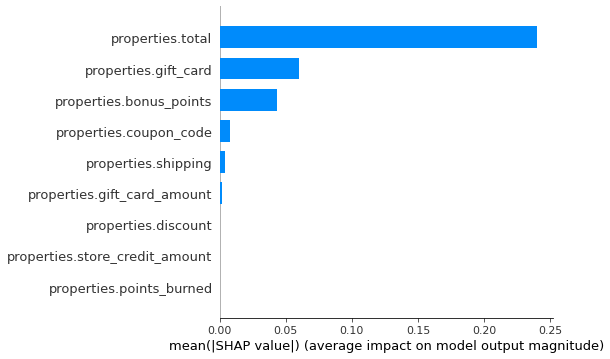

In [ ]:
shap_values = plot_shap_values(model, train)

In [ ]:
test_data_2 = test_data[:10000]
test_data_2 = np.array(test_data_2, dtype=float)
feature_names = [
    "properties.total",	
    "properties.points_burned",	
    "properties.discount",	
    "properties.shipping",	
    "properties.gift_card",	
    "properties.gift_card_amount",	
    "properties.coupon_code",	
    "properties.store_credit_amount",	
    "properties.bonus_points"]

explainer = shap.Explainer(model.predict, test_data_2, feature_names=feature_names)


In [ ]:
shap_values_explainer = explainer(test_data_2)

In [ ]:
shap_values_explainer.base_values

array([0.3086866, 0.3086866, 0.3086866, ..., 0.3086866, 0.3086866,
       0.3086866])

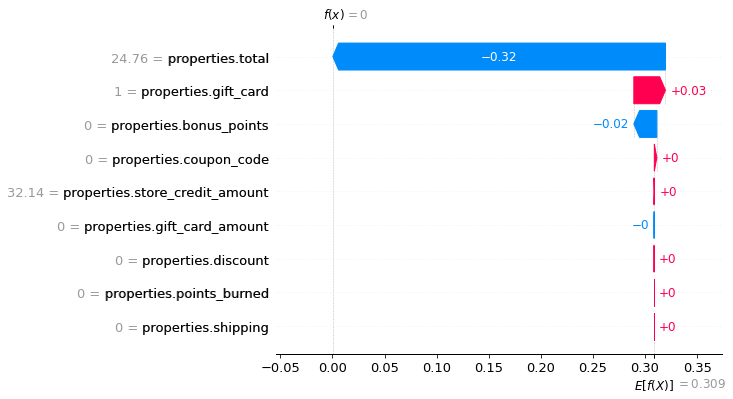

In [ ]:
shap.plots.waterfall(shap_values_explainer[0])

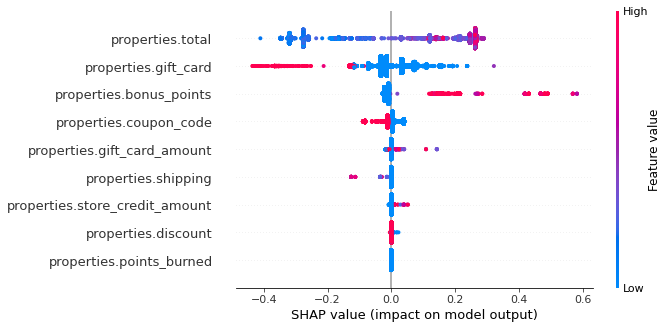

In [ ]:

shap.plots.beeswarm(shap_values_explainer)

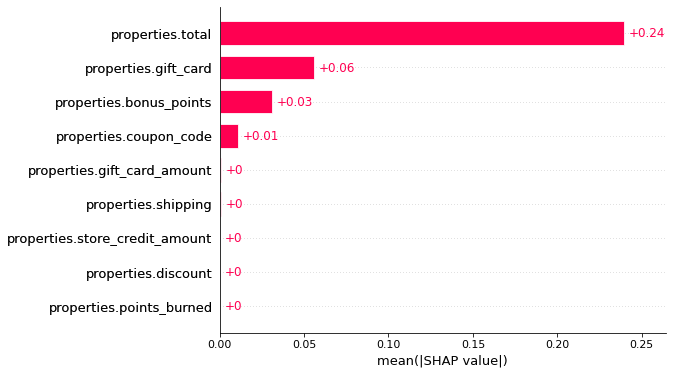

In [ ]:
shap.plots.bar(shap_values_explainer)

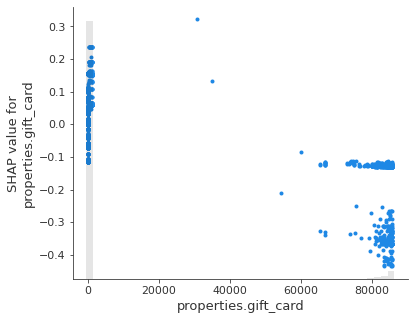

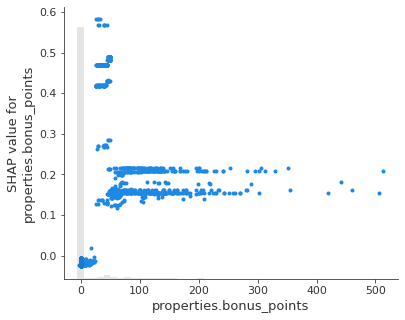

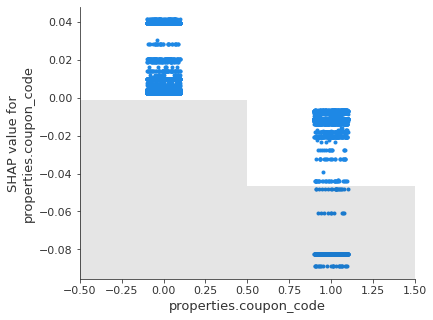

In [ ]:
shap.plots.scatter(shap_values_explainer[:,"properties.gift_card"])
shap.plots.scatter(shap_values_explainer[:,"properties.bonus_points"])
shap.plots.scatter(shap_values_explainer[:,"properties.coupon_code"])

In [ ]:
shap.plots.heatmap(shap_values_explainer)